In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.backends.cudnn as cudnn

import torchvision
from torchvision import transforms as T
from torchvision.datasets import CIFAR10

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

from torchmetrics import Accuracy
from tqdm import tqdm

In [ ]:
transform_train = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010]),
])

In [ ]:
train_set = CIFAR10(root='cifar10',
                    train=True,
                    download=True,
                    transform=transform_train)

In [ ]:
test_set = CIFAR10(root='cifar10',
                   train=False,
                   download=True,
                   transform=transform_train)

In [ ]:
train_set

In [ ]:
train_set[12][0]

In [ ]:
train_set[12]

In [ ]:
train_set.classes

In [ ]:
train_set.class_to_idx

In [ ]:
test_set

In [ ]:
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False)

In [ ]:
x, y = next(iter(train_loader))
print(x.shape, y.shape)

In [ ]:
def conv3x3_bn_af(in_channels, out_channels):
    module = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU())
    return module


In [ ]:
def CNN():
    network = nn.Sequential(
        conv3x3_bn_af(3, 64),
        conv3x3_bn_af(64, 64),
        nn.MaxPool2d(kernel_size=2, stride=2),

        conv3x3_bn_af(64, 128),
        conv3x3_bn_af(128, 128),
        nn.MaxPool2d(kernel_size=2, stride=2),

        conv3x3_bn_af(128, 256),
        conv3x3_bn_af(256, 256),
        nn.MaxPool2d(kernel_size=2, stride=2),

        conv3x3_bn_af(256, 512),
        conv3x3_bn_af(512, 512),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.AdaptiveAvgPool2d(output_size=(1, 1)),

        nn.Flatten(),
        nn.Linear(512, 10),  # classifier
    )
    return network

In [ ]:
# model(next(iter(train_loader)))
model = CNN()

In [ ]:
model[0][0].weight.shape

In [ ]:
model[0][0].bias.shape

In [ ]:
def num_params(model):
    nums = sum(p.numel() for p in model.parameters()) / 1e6
    return nums

In [ ]:
num_params(model)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)

In [ ]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


In [ ]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, epoch=None):
    model.train()
    loss_train = AverageMeter()
    acc_train = Accuracy(task='multiclass', num_classes=10).to(device)
    with tqdm(train_loader, unit='batch') as pbar:
        for x_batch, y_batch in pbar:
            if epoch is not None:
                pbar.set_description(f'Epoch {epoch}')
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            yp = model(x_batch)
            loss = loss_fn(yp, y_batch).to(device)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_train.update(loss.item())
            acc_train(yp, y_batch).to(device)
            pbar.set_postfix(loss=loss_train.avg, accuracy=100. * acc_train.compute().item())
    return model, loss_train.avg, acc_train.compute().item()


In [ ]:
def evaluate(model, valid_loader, loss_fn):
    model.eval()
    with torch.no_grad():
        loss_valid = AverageMeter()
        acc_valid = Accuracy(task='multiclass', num_classes=10).to(device)
        for i, (x_batch, y_batch) in enumerate(valid_loader):
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            yp = model(x_batch)
            loss = loss_fn(yp, y_batch).to(device)
            loss_valid.update(loss.item())
            acc_valid(yp, y_batch).to(device)
    return loss_valid.avg, acc_valid.compute().item()


In [ ]:
x_batch, y_batch = next(iter(train_loader))
outputs = model(x_batch.to(device))
loss = loss_fn(outputs, y_batch.to(device))
print(loss)

In [ ]:
_, mini_train_dataset = random_split(train_set, (len(train_set) - 100, 100))
mini_train_loader = DataLoader(mini_train_dataset, batch_size=20, shuffle=True)

In [ ]:
num_epochs = 10
for epoch in range(num_epochs):
    model, _, _ = train_one_epoch(model, mini_train_loader, loss_fn, optimizer, epoch)

In [ ]:
# select best Lr
num_epochs = 5
for lr in [0.1,0.01,0.001]:
    print(f'Learning rate: {lr}')
    model = CNN().to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=1e-4)
    for epoch in range(num_epochs):
        model,_,_ = train_one_epoch(model, train_loader, loss_fn, optimizer, epoch)
        print()

In [ ]:
#Create small grid based on the "weight_decay" and the "Learning rate"
num_epochs = 5
for lr in [0.08,0.09,0.1,0.15,0.2]:
    for wd in [1e-4,1e-5,0.]:
        model = CNN().to(device)
        optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd)
        print(f'Learning rate: {lr}, Weight decay: {wd}')
        for epoch in range(num_epochs):
            model,loss,_ = train_one_epoch(model, train_loader, loss_fn, optimizer, epoch)
        print()


In [273]:
# train the more epochs
model = CNN().to(device)

In [274]:
lr = 0.01
wd = 1e-4
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd)

In [275]:
loss_train_history = []
acc_train_history = []

loss_val_history = []
acc_val_history = []
best_loss_val = torch.inf
epoch_counter = 0

In [276]:
num_epochs = 5
for epoch in range(num_epochs):
    # train
    model, loss_train, acc_train = train_one_epoch(model, train_loader, loss_fn, optimizer, epoch)

    # validation
    loss_valid, acc_valid = evaluate(model, test_loader, loss_fn)

    loss_train_history.append(loss_train)
    acc_train_history.append(acc_train)
    loss_val_history.append(loss_valid)
    acc_val_history.append(acc_valid)

    if loss_valid < best_loss_val:
        torch.save(model, f'model.pt')
        best_loss_val = loss_valid
    print(f'Validation: Loss={loss_valid:.4}, Accuracy={acc_valid:.4}')
    print()

    epoch_counter += 1

Epoch 0: 100%|██████████| 782/782 [01:33<00:00,  8.36batch/s, accuracy=59, loss=1.14]  


Validation: Loss=1.263, Accuracy=0.5771



Epoch 1: 100%|██████████| 782/782 [01:33<00:00,  8.38batch/s, accuracy=75.1, loss=0.711]


Validation: Loss=0.8665, Accuracy=0.6971



Epoch 2: 100%|██████████| 782/782 [01:33<00:00,  8.38batch/s, accuracy=81.8, loss=0.524]


Validation: Loss=0.8944, Accuracy=0.7205



Epoch 3: 100%|██████████| 782/782 [01:33<00:00,  8.39batch/s, accuracy=86.3, loss=0.397]


Validation: Loss=1.782, Accuracy=0.5762



Epoch 4: 100%|██████████| 782/782 [01:33<00:00,  8.39batch/s, accuracy=90.4, loss=0.289]


Validation: Loss=0.819, Accuracy=0.7503



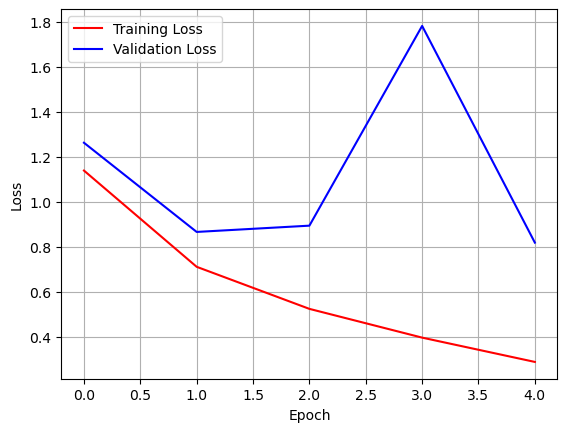

In [278]:
plt.plot(range(epoch_counter), loss_train_history,'r-', label='Training Loss')
plt.plot(range(epoch_counter), loss_val_history,'b-', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

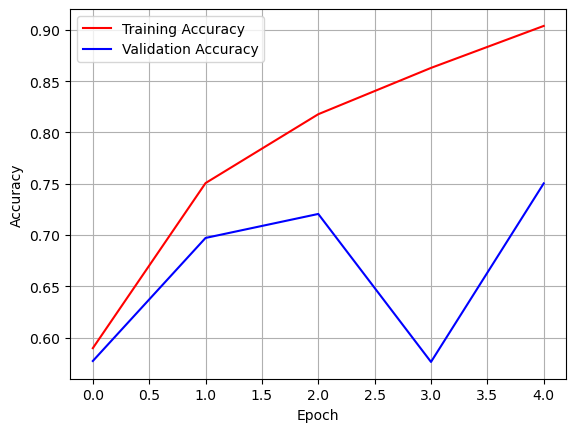

In [279]:
plt.plot(range(epoch_counter), acc_train_history,'r-', label='Training Accuracy')
plt.plot(range(epoch_counter), acc_val_history,'b-', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()